# Wstępnie trenowana konwolucyjna sieć neuronowa (ang. Pre-trained convolutional neural network) Inception ResNet V2 w analizie czerniaka

## Tworzymy model

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ln39_gyt because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Ładujemy dane do trenowania i walidacji.

In [2]:
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
training_set = datagen.flow_from_directory('/big-data',
                                           target_size=(299, 299),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='training')
validation_set = datagen.flow_from_directory('/big-data',
                                           target_size=(299, 299),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='validation')

Found 43922 images belonging to 9 classes.
Found 10975 images belonging to 9 classes.


Zapisujemy ilość diagnoz do zmiennej.

In [3]:
DIAGNOSIS_NUMBER = len(training_set.class_indices)

Budujemy model - sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
                   trainable=False),
    Dense(DIAGNOSIS_NUMBER, activation='softmax')
])
model.build([None, 299, 299, 3])

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dodajemy funkcjonalność zbierania danych o wydajności modelu do Tensorboard.

In [6]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('inception_resnet_v2')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Dodajemy funkcjonalność zapisywania modelu w trakcie jego trenowania. Zwóćmy uwagę, że zapisywany jest tylko jeden model i lepszy nadpisuje gorszy.

In [7]:
checkpoint_path = 'checkpoints/inception_resnet_v2.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto')

Dodajemy funkcjonalność zatrzymania trenowania modelu, jeśli nie będzie poprawy w ciągu 10 epoch.

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=10, restore_best_weights=True)

Trenujemy model.

In [9]:
model.fit(training_set, validation_data=validation_set, epochs=200, callbacks=[tensorboard_callback,
                                                                               checkpoint_callback,
                                                                               early_stop_callback])

Epoch 1/200
1373/1373 [==============================] - 4605s 3s/step - loss: 0.7886 - accuracy: 0.7213 - val_loss: 0.7891 - val_accuracy: 0.7605

Epoch 00001: val_loss improved from inf to 0.78906, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


Epoch 2/200
1373/1373 [==============================] - 4581s 3s/step - loss: 0.6733 - accuracy: 0.7652 - val_loss: 0.8065 - val_accuracy: 0.7264

Epoch 00002: val_loss did not improve from 0.78906
Epoch 3/200
1373/1373 [==============================] - 4583s 3s/step - loss: 0.6385 - accuracy: 0.7779 - val_loss: 0.8820 - val_accuracy: 0.7319

Epoch 00003: val_loss did not improve from 0.78906
Epoch 4/200
1373/1373 [==============================] - 4572s 3s/step - loss: 0.6162 - accuracy: 0.7846 - val_loss: 0.7706 - val_accuracy: 0.7513

Epoch 00004: val_loss improved from 0.78906 to 0.77061, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


Epoch 5/200
1373/1373 [==============================] - 4576s 3s/step - loss: 0.6012 - accuracy: 0.7882 - val_loss: 0.7721 - val_accuracy: 0.7635

Epoch 00005: val_loss did not improve from 0.77061
Epoch 6/200
1373/1373 [==============================] - 4578s 3s/step - loss: 0.5882 - accuracy: 0.7926 - val_loss: 0.7042 - val_accuracy: 0.7858

Epoch 00006: val_loss improved from 0.77061 to 0.70425, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


Epoch 7/200
1373/1373 [==============================] - 4580s 3s/step - loss: 0.5776 - accuracy: 0.7958 - val_loss: 0.7953 - val_accuracy: 0.7569

Epoch 00007: val_loss did not improve from 0.70425
Epoch 8/200
1373/1373 [==============================] - 4578s 3s/step - loss: 0.5695 - accuracy: 0.7995 - val_loss: 0.6983 - val_accuracy: 0.7876

Epoch 00008: val_loss improved from 0.70425 to 0.69832, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


Epoch 9/200
1373/1373 [==============================] - 4592s 3s/step - loss: 0.5605 - accuracy: 0.8023 - val_loss: 0.7550 - val_accuracy: 0.7645

Epoch 00009: val_loss did not improve from 0.69832
Epoch 10/200
1373/1373 [==============================] - 4639s 3s/step - loss: 0.5548 - accuracy: 0.8049 - val_loss: 0.8094 - val_accuracy: 0.7457

Epoch 00010: val_loss did not improve from 0.69832
Epoch 11/200
1373/1373 [==============================] - 4575s 3s/step - loss: 0.5495 - accuracy: 0.8047 - val_loss: 0.8324 - val_accuracy: 0.7547

Epoch 00011: val_loss did not improve from 0.69832
Epoch 12/200
1373/1373 [==============================] - 4579s 3s/step - loss: 0.5430 - accuracy: 0.8072 - val_loss: 0.7469 - val_accuracy: 0.7760

Epoch 00012: val_loss did not improve from 0.69832
Epoch 13/200
1373/1373 [==============================] - 4570s 3s/step - loss: 0.5352 - accuracy: 0.8106 - val_loss: 0.7195 - val_accuracy: 0.7882

Epoch 00013: val_loss did not improve from 0.69832
E

## Szacujemy dokładność modelu

Ładujemy dane do testowania.

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)
testing_set = datagen.flow_from_directory('/big-data-test',
                                           target_size=(299, 299),
                                           batch_size=32,
                                           class_mode='categorical')

Found 2889 images belonging to 9 classes.


Pobieramy diagnozy z danych testowych.

In [11]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

Prognozujemy diagnozy dla każdego obrazu.

In [12]:
predicted_labels = model.predict(testing_set)

Obliczamy punkty wykresu ROC (Receiver operating characteristic) i metrykę AUC (Area under the curve).

In [13]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in training_set.class_indices.items()}

for i in range(DIAGNOSIS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

Rysujemy wykres ROC (Receiver operating characteristic).

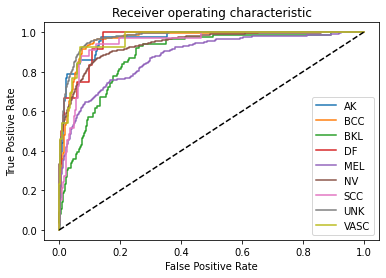

In [14]:
for diagnosis in training_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Metryki AUC do każdej diagnozy.

In [15]:
auc_metric

{'AK': 0.9650999362630538,
 'BCC': 0.9633126365662116,
 'BKL': 0.8813273154178661,
 'DF': 0.9620843471208436,
 'MEL': 0.8778601738557245,
 'NV': 0.9411366260671269,
 'SCC': 0.9439351498175028,
 'UNK': 0.9741551814771059,
 'VASC': 0.9645073285546164}